# Welcome to the CloudtoStreet Machine Learning Challenge

Hi, I am Philip, the Machine Learning team lead here at CloudtoStreet. This challenge is testing your skills in training, evaluating and designing Deep Learning models for Computer Vision.

Depending on how often you have done such tasks, the challenge can take longer or shorter. We aim for 3-4 hours and don't expect your solution to be perfect, it's just helping us to see where you are and will inform the questions we will ask in the interviews.

__You can (and should because of time constraints) re-use code (models, datasets, training loops) from open sources or your personal work as long as you cite them.__

Note: If you do not have a GPU at hand, you can use https://www.kaggle.com/kernels, https://colab.research.google.com/ for free GPUs or rent a cheap GPU at https://vast.ai/console/create/.

__Some specific tasks for you are tagged in this notebook with "Todo". Please follow these prompts and add any cells you need.__

Good luck!

In [1]:
# these are the packages we need for exploration, please install them e.g. in colab you need !pip install rasterio
import os
import glob
import matplotlib.pyplot as plt
import tifffile
import numpy as np

from matplotlib.collections import PatchCollection
from shapely.geometry import Polygon
from rasterio.features import shapes
from descartes import PolygonPatch

In [2]:
#BH: packages I brought in myself

import pandas as pd
import tensorflow as tf
import json
import tqdm

In [3]:
#BH: Some known constants

IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
IMAGE_SIZE = IMAGE_HEIGHT * IMAGE_WIDTH

In [24]:
# Random seed for reproducible results (running the notebook end-to-end)

tf.random.set_seed(303)

# Setup

We will use our [Sen1Floods11](https://github.com/cloudtostreet/Sen1Floods11) dataset. We will create a local folder `c2s_data/v1.1/data/flood_events/HandLabeled` and download the handlabeled training data (Sentinel-1 512x512 chips, mask labels) there.

In [4]:
if False:
    os.makedirs("c2s_data/v1.1/data/flood_events/HandLabeled", exist_ok=True)

    !pip install gsutil
    !gsutil -m rsync -r gs://sen1floods11/v1.1/data/flood_events/HandLabeled c2s_data/v1.1/data/flood_events/HandLabeled

There are some faulty labels we will remove here.

In [5]:
def remove_faulty(img_folder="c2s_data/v1.1/data/flood_events/HandLabeled/S1Hand", 
                  label_folder="c2s_data/v1.1/data/flood_events/HandLabeled/LabelHand"):
    for uid in [
        'Ghana_141910',
        'Ghana_866994',
        'Mekong_1111068',
        'Pakistan_35915',
        'Pakistan_94095',
        'Paraguay_34417',
        'Paraguay_581976',
        'Spain_6095801'
    ]:
        
        faulty_img = f"{img_folder}/{uid}_S1Hand.tif"
        if os.path.exists(faulty_img):
            print('removing: ', faulty_img)
            os.remove(faulty_img)

        faulty_label = f"{label_folder}/{uid}_LabelHand.tif"
        if os.path.exists(faulty_label):
            print('removing: ', faulty_label)
            os.remove(faulty_label)

remove_faulty()

## Helper functions

In [6]:
def get_patchcollection_from_label(label, label_value=1, alpha=1, color="cyan"):
    """Turns a (H,W) mask into a PatchCollection of polygons"""
    polygons, colors = [], []
    for geom in shapes((label == label_value).astype(np.uint8), mask=(label == label_value).astype(np.uint8),
                       connectivity=4):
        poly = Polygon(geom[0]['coordinates'][0], holes=geom[0]['coordinates'][1:])
        polygons.append(PolygonPatch(poly.buffer(0)))
        colors.append(color)
    return PatchCollection(polygons, facecolor=colors, linewidths=0, alpha=alpha)

def visualize_s1_img(path):
    """Opens a Sentinel 1 image and returns a scaled RFCC false color composite image for visualization."""
    s1_img = tifffile.imread(path)
    if s1_img.shape[0] < 15: s1_img = np.transpose(s1_img, (1, 2, 0))
    if s1_img.shape[-1] == 3: s1_img = s1_img[:, :, :2]
    img = np.zeros((s1_img.shape[0], s1_img.shape[1], 3), dtype=np.float32)
    img[:, :, :2] = s1_img
    img[:, :, 2] = s1_img[:, :, 0] / s1_img[:, :, 1]
    return scale_S1_S2_img(img)

def scale_S1_S2_img(matrix):
    """Returns a scaled (H,W,D) image which is more easily visually inspectable. Image is linearly scaled between
    min and max_value of by channel"""
    w, h, d = matrix.shape
    min_values = np.array([-23, -28, 0.2])
    max_values = np.array([0, -5, 1])

    matrix = np.reshape(matrix, [w * h, d]).astype(np.float32)
    matrix = (matrix - min_values[None, :]) / (max_values[None, :] - min_values[None, :])
    matrix = np.reshape(matrix, [w, h, d])

    matrix = matrix.clip(0, 1)
    return matrix

# Part 1: Practical Deep Learning

## Exploration and Splitting

In the folder "S1Hand" we have 438 512x512 Sentinel-1 images from 11 countries. The folder "LabelHand" contains the water/no data masks for these images. 

Our goal is to have a model that achieves high mean Intersection over Union over all countries. 

__Todo__
- Look at the images with the code that is given. Re-run it to see different random examples from the dataset.
- Explore the images and labels. Summarize your findings with relevant statistics and visualizations.
- Split the data into useful train/validation/test datasets

__My Responses__
- First I did a bit of data cleanup: I threw out some images where less that 20 percent of the pixels had a ground truth label.
- I created a 80/10/10 train/validation/test split for each country. There is relatively little data so I reserved most of it for training.
- As a quality check on these splits, I visualized the mean per-image water content, and the mean per-image percent of unknown pixels. These graphs are below.

In [7]:
# Countries we have data for
countries_present = list(set([k.split("/")[-1].split("_")[0] for k in glob.glob("c2s_data/v1.1/data/flood_events/HandLabeled/S1Hand/*.tif")]))
print(countries_present)

['Ghana', 'Sri-Lanka', 'India', 'Mekong', 'Pakistan', 'Paraguay', 'Somalia', 'Spain', 'Bolivia', 'USA', 'Nigeria']


In [8]:
S1_imgs = sorted(glob.glob("c2s_data/v1.1/data/flood_events/HandLabeled/S1Hand/*.tif"))
labels_GT = sorted(glob.glob("c2s_data/v1.1/data/flood_events/HandLabeled/LabelHand/*.tif"))
print(len(S1_imgs), len(labels_GT))

438 438


For Visualization we are using a false color composite of the two Sentinel-1 channels and some color stretching. 

The label masks are 1 for water pixels (shown in cyan) and -1 for no data, e.g. clouds on the Sentinel-2 image we labeled the data on (shown in magenta).

Mekong_98310_S1Hand.png


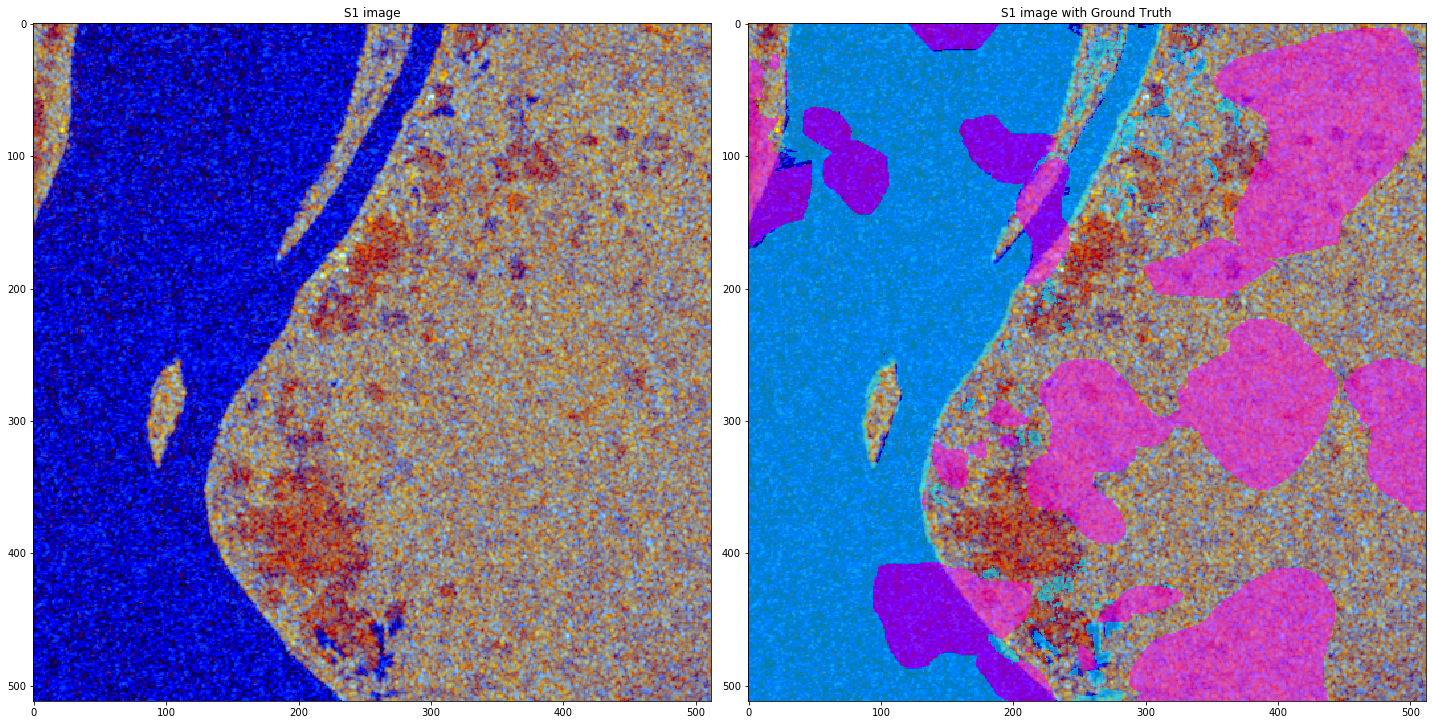

Somalia_205466_S1Hand.png


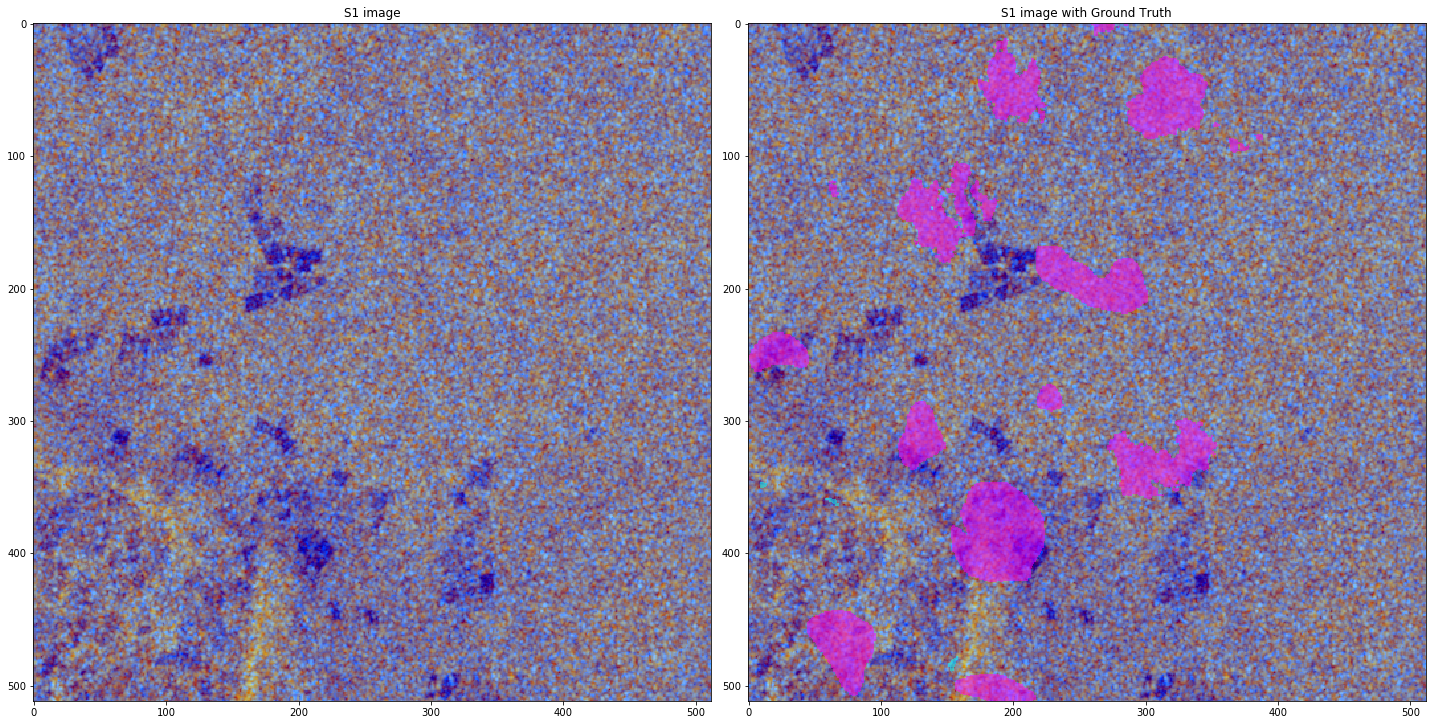

In [9]:
# plot random tiles
# S1 image on the left, and the S1 image with the hand-labels overlain on the right.
show_how_many = 2
color = "cyan"
no_data_color = "magenta"
alpha = 0.5
for k in range(show_how_many):
    rand_int = np.random.randint(len(S1_imgs))
    filename = S1_imgs[rand_int].split("/")[-1].split(".")[0] + ".png"
    f, axarr = plt.subplots(1, 2, figsize=(20, 10))
    print(filename)
    img = visualize_s1_img(S1_imgs[rand_int])
    axarr[0].imshow(img)
    axarr[0].set_title("S1 image")
    axarr[1].imshow(img)
    axarr[1].set_title("S1 image with Ground Truth")
         
    label = tifffile.imread(labels_GT[rand_int])
    p = get_patchcollection_from_label(label, alpha=alpha, color=color)
    axarr[1].add_collection(p)
    p = get_patchcollection_from_label(label, -1, alpha=alpha, color=no_data_color)
    axarr[1].add_collection(p)
    
    plt.tight_layout()
    plt.show()

Generate a summary dataframe:

In [10]:
perc_unknown_list = []
perc_water_known_list = []
perc_dry_known_list = []
country_list = []
asset_id_list = []
label_fp_list = []
image_fp_list = []

for i, filepath in enumerate(labels_GT):
    label = tifffile.imread(filepath)
    image_fp = S1_imgs[i]
    image = tifffile.imread(image_fp)
    
    asset_id = filepath.split("/")[-1].replace("_LabelHand.tif", "")
    country = filepath.split("/")[-1].split("_")[0]
    
    num_unknown_pixels = len(label[label == -1])
    num_dry_pixels = len(label[label == 0])
    num_water_pixels = len(label[label == 1])
    perc_unknown = num_unknown_pixels / IMAGE_SIZE
    try:
        perc_water_known = num_water_pixels / (IMAGE_SIZE - num_unknown_pixels)
        perc_dry_known = num_dry_pixels / (IMAGE_SIZE - num_unknown_pixels)
    except:
        perc_water_known = 0
        perc_dry_known = 0
        
    perc_unknown_list.append(perc_unknown)
    perc_water_known_list.append(perc_water_known)
    perc_dry_known_list.append(perc_dry_known)
    country_list.append(country)
    asset_id_list.append(asset_id)
    label_fp_list.append(filepath)
    image_fp_list.append(image_fp)
    
summary_df = pd.DataFrame.from_dict({'perc_unknown' : perc_unknown_list,
                                     'perc_water_known' : perc_water_known_list,
                                     'perc_dry_known' : perc_dry_known_list,
                                     'country' : country_list,
                                     'asset_id' : asset_id_list,
                                     'label_fp' : label_fp_list,
                                     'image_fp' : image_fp_list})

summary_df.set_index('asset_id', inplace = True)
summary_df

perc_unknown  perc_water_known  perc_dry_known  country  \
asset_id                                                                  
Bolivia_103757      0.664013          0.401490        0.598510  Bolivia   
Bolivia_129334      0.092812          0.658679        0.341321  Bolivia   
Bolivia_195474      0.003086          0.005935        0.994065  Bolivia   
Bolivia_23014       0.200901          0.037140        0.962860  Bolivia   
Bolivia_233925      0.425747          0.000007        0.999993  Bolivia   
...                      ...               ...             ...      ...   
USA_908474          0.000278          0.007044        0.992956      USA   
USA_933610          0.000446          0.014590        0.985410      USA   
USA_955053          0.000015          0.136713        0.863287      USA   
USA_986268          0.000080          0.034686        0.965314      USA   
USA_994009          0.000481          0.007240        0.992760      USA   

                                                         label_fp  \
asset_id                                                            
Bolivia_103757  c2s_data/v1.1/data/flood_events/HandLabeled/La...   
Bolivia_129334  c2s_data/v1.1/data/flood_events/HandLabeled/La...   
Bolivia_195474  c2s_data/v1.1/data/flood_events/HandLabeled/La...   
Bolivia_23014   c2s_data/v1.1/data/flood_events/HandLabeled/La...   
Bolivia_233925  c2s_data/v1.1/data/flood_events/HandLabeled/La...   
...                                                           ...   
USA_908474      c2s_data/v1.1/data/flood_events/HandLabeled/La...   
USA_933610      c2s_data/v1.1/data/flood_events/HandLabeled/La...   
USA_955053      c2s_data/v1.1/data/flood_events/HandLabeled/La...   
USA_986268      c2s_data/v1.1/data/flood_events/HandLabeled/La...   
USA_994009      c2s_data/v1.1/data/flood_events/HandLabeled/La...   

                                                         image_fp  
asset_id                                                           
Bolivia_103757  c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
Bolivia_129334  c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
Bolivia_195474  c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
Bolivia_23014   c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
Bolivia_233925  c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
...                                                           ...  
USA_908474      c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
USA_933610      c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
USA_955053      c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
USA_986268      c2s_data/v1.1/data/flood_events/HandLabeled/S1...  
USA_994009      c2s_data/v1.1/data/flood_events/HandLabeled/S1...  

[438 rows x 6 columns]

Some data cleanup: take out images with low label quality

In [11]:
quality_threshold = .8
print("removing %d images because of low label quality" % len(summary_df[summary_df['perc_unknown'] >= quality_threshold]))
summary_df = summary_df[summary_df['perc_unknown'] < quality_threshold]

removing 15 images because of low label quality


Form dataset splits, on a per-country level. Here I'm assuming images aren't overlapping, so there is no problem with having one country appear in all three splits. In fact, this must be the case since in the problem statement we're trying to maximise test IoU averaged over all countries.

In [12]:
train_perc = .8
val_perc = .1
test_perc = 1 - train_perc - val_perc

asset_splits = {'train' : [], 'val' : [], 'test' : []}

seed = 607
rng = np.random.default_rng(seed = seed)

for country in countries_present:
    country_assets = summary_df[summary_df['country'] == country].index
    country_assets = list(rng.permutation(country_assets))

    total_country_assets = len(country_assets)
    num_val_assets = np.int(np.ceil(total_country_assets * val_perc))
    num_test_assets = np.int(np.ceil(total_country_assets * test_perc))

    asset_splits['val'].extend(country_assets[:num_val_assets])
    asset_splits['test'].extend(country_assets[num_val_assets: num_test_assets + num_val_assets])
    asset_splits['train'].extend(country_assets[num_test_assets + num_val_assets:])

splits_dict = {asset_id : key for key in asset_splits for asset_id in asset_splits[key]}

In [13]:
# These are the final dataframes we'll use

summary_df = summary_df.merge(pd.DataFrame.from_dict(splits_dict, orient = 'index', columns = ['split']),
                              left_index = True, right_index = True)

train_df = summary_df[summary_df['split'] == 'train']
val_df = summary_df[summary_df['split'] == 'val']
test_df = summary_df[summary_df['split'] == 'test']

Sanity check: Visualize the splits

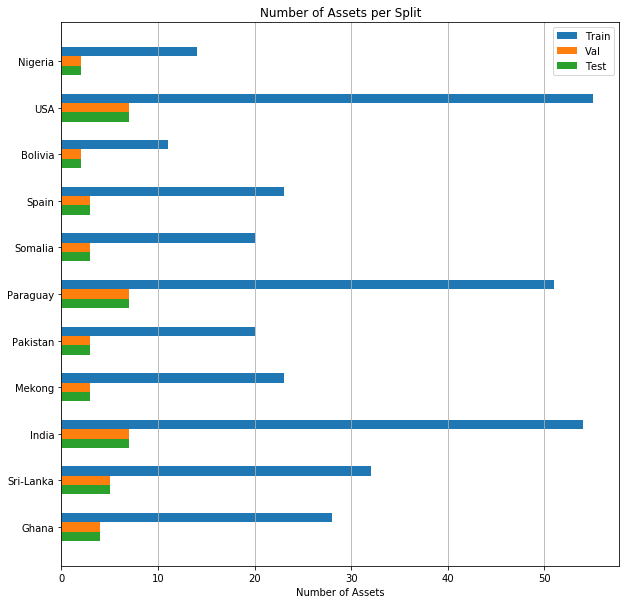

In [14]:
train_counts = {country : len(train_df[train_df['country'] == country]) for country in countries_present}
val_counts = {country : len(val_df[val_df['country'] == country]) for country in countries_present}
test_counts = {country : len(test_df[test_df['country'] == country]) for country in countries_present}

y_pos = np.arange(len(countries_present))
width = 0.2

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1,1,1)
rects1 = ax.barh(y_pos + width, [train_counts[country] for country in countries_present], width, label='Train') # train "first"
rects2 = ax.barh(y_pos, [val_counts[country] for country in countries_present], width, label='Val') # val "middle"
rects3 = ax.barh(y_pos - width, [test_counts[country] for country in countries_present], width, label='Test')   # test "below"

ax.set_xlabel('Number of Assets')
ax.set_title('Number of Assets per Split')
ax.set_yticks(y_pos)
ax.set_yticklabels(countries_present)

ax.legend()
ax.grid(axis='x')
fig.show()

Quality Check: Visualize some summary statistics

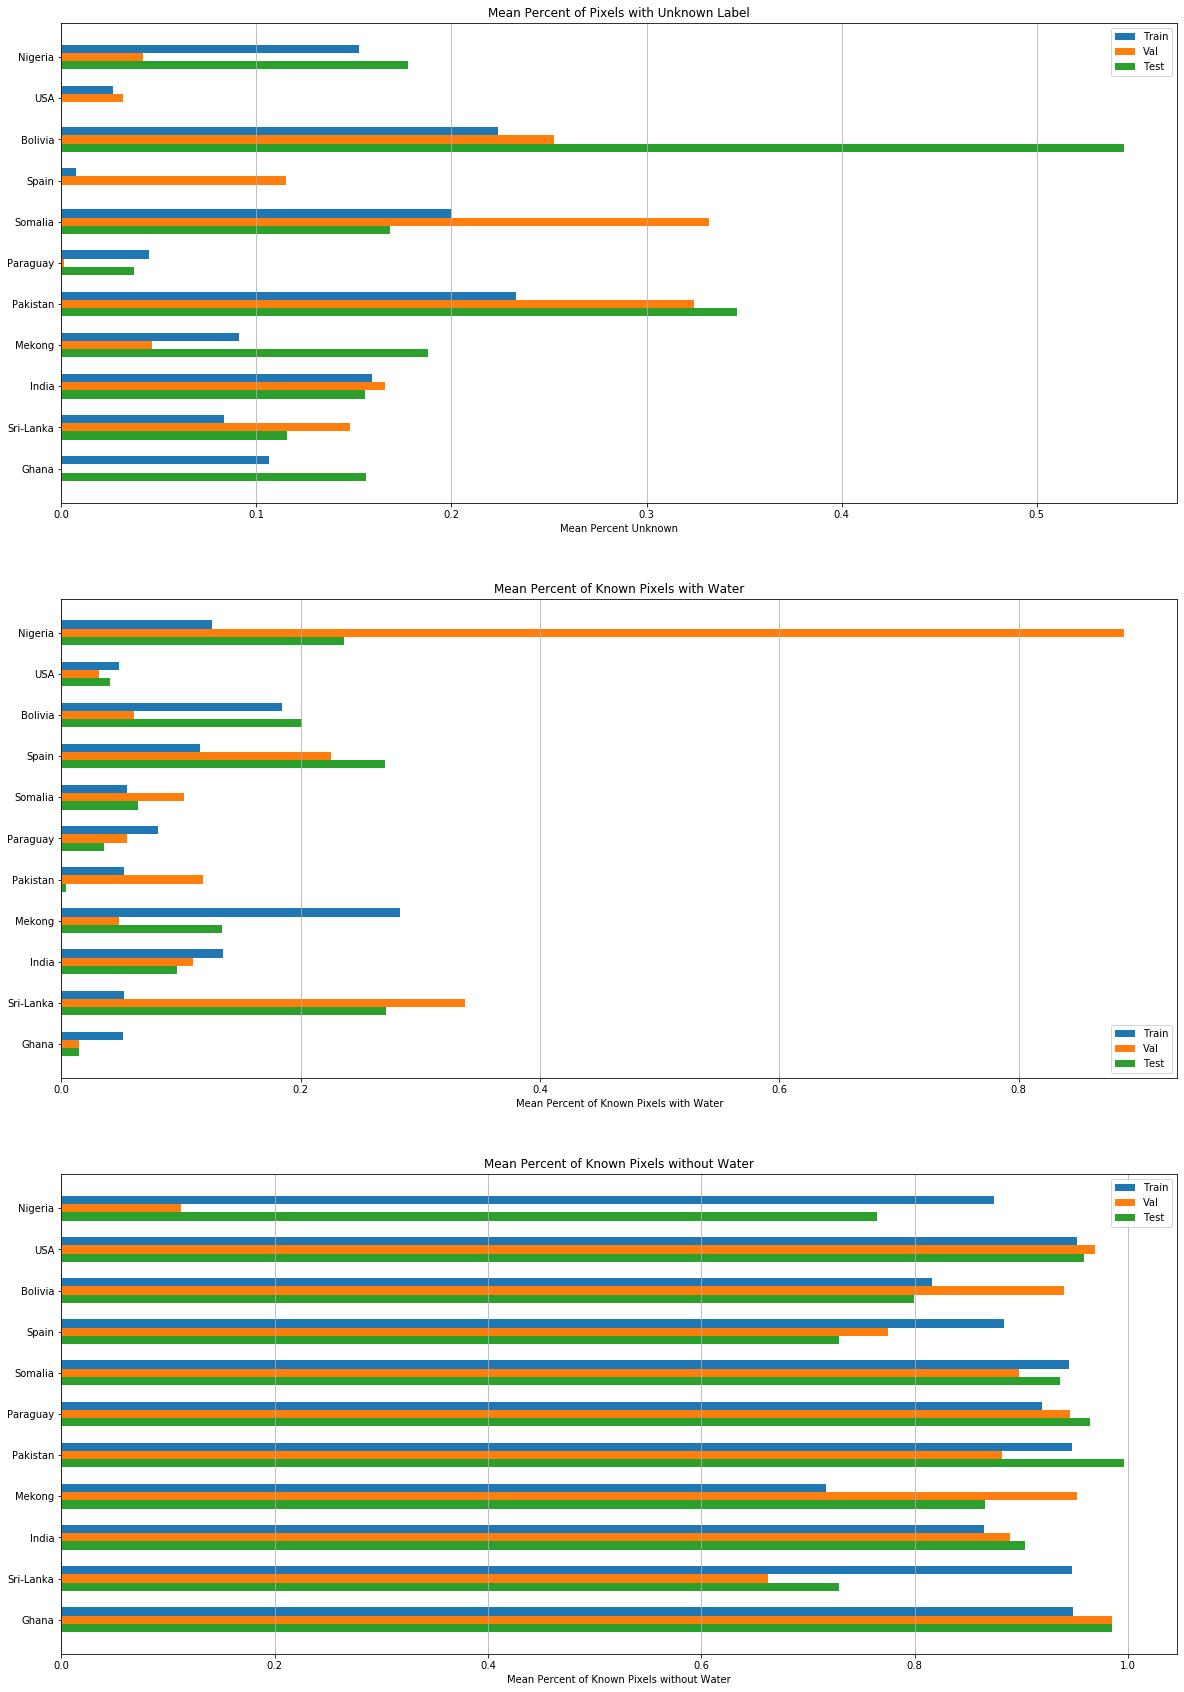

In [15]:
y_pos = np.arange(len(countries_present))
width = 0.2

fig = plt.figure(figsize=(20, 30))

## Visualize percent unknown

ax = fig.add_subplot(3,1,1)
rects1 = ax.barh(y_pos + width, [train_df[train_df['country'] == country].mean()['perc_unknown'] for country in countries_present], width, label='Train') # train "first"
rects2 = ax.barh(y_pos, [val_df[val_df['country'] == country].mean()['perc_unknown'] for country in countries_present], width, label='Val') # val "middle"
rects3 = ax.barh(y_pos - width, [test_df[test_df['country'] == country].mean()['perc_unknown'] for country in countries_present], width, label='Test')   # test "below"

ax.set_xlabel('Mean Percent Unknown')
ax.set_title('Mean Percent of Pixels with Unknown Label')
ax.set_yticks(y_pos)
ax.set_yticklabels(countries_present)

ax.legend()
ax.grid(axis='x')

## Visualize percent known water

ax = fig.add_subplot(3,1,2)
rects1 = ax.barh(y_pos + width, [train_df[train_df['country'] == country].mean()['perc_water_known'] for country in countries_present], width, label='Train') # train "first"
rects2 = ax.barh(y_pos, [val_df[val_df['country'] == country].mean()['perc_water_known'] for country in countries_present], width, label='Val') # val "middle"
rects3 = ax.barh(y_pos - width, [test_df[test_df['country'] == country].mean()['perc_water_known'] for country in countries_present], width, label='Test')   # test "below"

ax.set_xlabel('Mean Percent of Known Pixels with Water')
ax.set_title('Mean Percent of Known Pixels with Water')
ax.set_yticks(y_pos)
ax.set_yticklabels(countries_present)

ax.legend()
ax.grid(axis='x')

# Visualize percent known dry

ax = fig.add_subplot(3,1,3)
rects1 = ax.barh(y_pos + width, [train_df[train_df['country'] == country].mean()['perc_dry_known'] for country in countries_present], width, label='Train') # train "first"
rects2 = ax.barh(y_pos, [val_df[val_df['country'] == country].mean()['perc_dry_known'] for country in countries_present], width, label='Val') # val "middle"
rects3 = ax.barh(y_pos - width, [test_df[test_df['country'] == country].mean()['perc_dry_known'] for country in countries_present], width, label='Test')   # test "below"

ax.set_xlabel('Mean Percent of Known Pixels without Water')
ax.set_title('Mean Percent of Known Pixels without Water')
ax.set_yticks(y_pos)
ax.set_yticklabels(countries_present)

ax.legend()
ax.grid(axis='x')
fig.show()

## Training

__Todo__
- Train a segmentation model in a deep learning framework of your choice (preferably PyTorch) using your train/val/test splits and the S1 images and masks. Validate on the average of the IoUs of individual countries and save your best models for validation and testing.
- Think about and implement how to treat the "no data" pixel values.

Reminder: If you do not have a GPU at hand, you can use https://www.kaggle.com/kernels, https://colab.research.google.com/ for free GPUs or rent a cheap GPU at https://vast.ai/console/create/.

__My Responses:__

- I trained a U-Net which used a pretrained (on imagenet) ResNet-50 as an encoder. I performed a grid search to tune a small set of hyperparameters. Hyperparameters were optimized to maximise the average of the IoU's of individual countries. The optimal hyperparameters are contained in the next cell. Code for running a grid search is at the end of this section.
- The "no data" pixel values were treated in two ways. First, I wrote a custom loss function (based on binary cross entropy) which ignored the "no data" pixels for the purpose of computing loss. Second, for evaluating the model's predictions I wrote a custom metric which computed IoU using only pixels with ground truth data.
- To avoid overfitting to the train or val datasets, I implemented a random flip augmentation.

In [16]:
# Optimal Hyperparameters

demo_configs = {'learning_rate' : .001, 'head_size' : 1, 'threshold' : 0.}

# Specify some training parameters

BATCH_SIZE = 32
DTYPE = tf.float32

Create the Training Dataset

In [17]:
def create_example(asset_id):
    image_fp = os.path.join('c2s_data/v1.1/data/flood_events/HandLabeled/S1Hand', asset_id + '_S1Hand.tif')
    
    # Using the pre-built image reading function since I don't know what the bands are supposed to represent 
    # Also, with 3 channels I can use pretrained model weights easily 
    image = visualize_s1_img(image_fp)
    image = np.nan_to_num(image)
    return image

def create_label(asset_id):
    label_fp = os.path.join('c2s_data/v1.1/data/flood_events/HandLabeled/LabelHand', asset_id + '_LabelHand.tif')
    
    return tifffile.imread(label_fp)

def build_tf_dataset(df, shuffle = True):
    image_dataset = tf.data.Dataset.from_tensor_slices([tf.cast(create_example(x), DTYPE) for x in sorted(df.index)])
    label_dataset = tf.data.Dataset.from_tensor_slices([create_label(x) for x in sorted(df.index)])
    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))
    if shuffle:
        dataset = dataset.shuffle(len(df))
    return dataset

def apply_random_flip(image, label):
    # Flipping function requires a channels axis
    label = tf.expand_dims(label, axis = -1)
    
    # Flip half the time
    apply_hor_flip = tf.cast(tf.floor(tf.random.uniform([], dtype=tf.float32) + 0.5), tf.bool)
    image = tf.cond(apply_hor_flip, lambda: tf.image.flip_left_right(image), lambda: image)
    label = tf.cond(apply_hor_flip, lambda: tf.image.flip_left_right(label), lambda: label)
    
    apply_vert_flip = tf.cast(tf.floor(tf.random.uniform([], dtype=tf.float32) + 0.5), tf.bool)
    image = tf.cond(apply_vert_flip, lambda: tf.image.flip_up_down(image), lambda: image)
    label = tf.cond(apply_vert_flip, lambda: tf.image.flip_up_down(label), lambda: label)
    
    label = tf.reshape(label, [IMAGE_HEIGHT, IMAGE_WIDTH])
    return image, label
    
print("Loading images, this may take a minute")

train_dataset = build_tf_dataset(train_df)
train_dataset = train_dataset.map(apply_random_flip)
train_dataset = train_dataset.batch(BATCH_SIZE)

print("Loaded train images")

val_dataset = build_tf_dataset(val_df)
val_dataset = val_dataset.batch(BATCH_SIZE)

print("Loaded val images")

Loading images, this may take a minute
Loaded train images
Loaded val images


Build the model.

In [31]:
def upsample(filters, size, apply_dropout=False):
    # This is an upsample block implemented in https://www.tensorflow.org/tutorials/generative/pix2pix
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
            padding='same',
            kernel_initializer=initializer,
            use_bias=False)
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())
    return result

def build_model(configs):
    # Loosely based on some code from the keras tutorial https://www.tensorflow.org/tutorials/images/segmentation
    
    ###
    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights="imagenet",
        classes=1,
        input_shape = [IMAGE_HEIGHT, IMAGE_WIDTH, 3]
    )
    
    #Use the activations of these layers
    layer_names = [
        'conv1_relu',             # 256x256
        'conv2_block3_out',       # 128x128
        'conv3_block4_out',       # 64x64 
        'conv4_block6_out',       # 32x32
        'conv5_block3_out'        # 16x16
    ]
    ###
    
    base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
    
    # Create the feature extractor
    encoder = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
    encoder.trainable = False
    
    # Create the U-net model
    inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3])
    
    x = tf.keras.applications.resnet50.preprocess_input(inputs)
    
    # Downsampling through the model
    skips = encoder(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    ###
    decoder = [
        upsample(1024, 3),  # 16x16 -> 32x32
        upsample(512, 3),  # 32x32 -> 64x64
        upsample(256, 3),  # 64x64 -> 128x128
        upsample(64, 3)   # 128x128 -> 256x256
    ]
    ###

    # Upsampling and establishing the skip connections
    for up, skip in zip(decoder, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    # Final Layer 256x256 -> 512x512
    # 32 is better than 64
    x = upsample(16, 3)(x)
    
    # Predictions using a single convoluation
    predictions = tf.keras.layers.Conv2D(1, configs['head_size'], strides=1, padding='same')(x)
    predictions = tf.keras.layers.Reshape([IMAGE_HEIGHT, IMAGE_WIDTH])(predictions)
    
    return tf.keras.Model(inputs = inputs, outputs = predictions)

model = build_model(demo_configs)

Implement IoU as a metric, with pixels without ground truth label making no contribution

In [32]:
class IoUMasked(tf.keras.metrics.Metric):

    def __init__(self, threshold = 0., name='iou_masked', **kwargs):
        super(IoUMasked, self).__init__(name=name, **kwargs)
        
        self.threshold = threshold
        self.intersection = self.add_weight(name='intersection', initializer='zeros')
        self.union = self.add_weight(name='union', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_gt_pos = tf.equal(y_true, 1)   # known true labels
        y_gt_neg = tf.equal(y_true, 0)   # known false labels
        
        y_pred = tf.math.greater(y_pred, self.threshold)   # predicted true
        
        tp = tf.logical_and(tf.equal(y_gt_pos, True), tf.equal(y_pred, True))
        fp = tf.logical_and(tf.equal(y_gt_neg, True), tf.equal(y_pred, True)) #False positives (only looking at pixels with known ground truth no water)
        
        tp = tf.cast(tp, self.dtype)
        fp = tf.cast(fp, self.dtype)
        y_gt_pos = tf.cast(y_gt_pos, self.dtype)
        
        union = tf.reduce_sum(fp) + tf.reduce_sum(y_gt_pos)
        intersection = tf.reduce_sum(tp)
        
        self.intersection.assign_add(intersection)
        self.union.assign_add(union)

    def result(self):
        return tf.math.divide_no_nan(self.intersection, self.union)

    def reset_states(self):
        self.intersection.assign(0)
        self.union.assign(0)

Implement a custom loss function, in which pixels without ground truth label add no loss. 

In [33]:
def BCE_masked_loss(y_true, y_pred):
    # Assumes predictions are given as logits
    
    # Compute naive pixel-wise BCE
    y_labels = tf.math.maximum(y_true, 0)
    y_labels = tf.cast(y_labels, DTYPE)
    cross_entropy_from_logits = tf.math.log(tf.math.exp((1.-y_labels) * y_pred) + tf.math.exp(- y_labels * y_pred))
    
    # Mask out values without ground truth label
    y_mask = tf.not_equal(y_true, -1)
    y_mask = tf.cast(y_mask, DTYPE)
    masked_cross_entropy = cross_entropy_from_logits * y_mask
    
    # Average over pixels with known ground truth label
    total_masked_cross_entropy = tf.reduce_sum(masked_cross_entropy)
    total_known_pixels = tf.reduce_sum(y_mask)
    
    return tf.math.divide_no_nan(total_masked_cross_entropy, total_known_pixels)

During training, we just keep track of mean IoU, without paying attention to countries. At the end of training, we need to run a detailed evaluation which keeps track of countries. Here random flip augmentations are applied to the validation data to reduce overfitting. The val datasets are repeated in order to take advantage of these augmentations.

As part of this detailed evaluation setup, I also included the ability to sweep through thresholds at which to compute IoU. This will be used in hyperparameter tuning, later on.

In [34]:
def create_detailed_dataset(df, flip = True):
    detailed_data_dict = {}
    for country in countries_present:
        ds = build_tf_dataset(df[df['country'] == country])
        if flip:
            ds = ds.repeat(8)
            ds = ds.map(apply_random_flip)
        ds = ds.batch(BATCH_SIZE)
        detailed_data_dict[country] = ds
    return detailed_data_dict

val_detail_dataset = create_detailed_dataset(val_df)

def run_detailed_evaluation(model, detailed_data_dict, thresholds = [0.]):
    print("Now running detailed evaluation")
    model.compile(optimizer='adam',
                  loss=BCE_masked_loss,
                  metrics=[IoUMasked(name = "IoU thresh = %.2f" % threshold, threshold = threshold) for threshold in thresholds])
    
    iou_dict = {threshold : {country : model.evaluate(detailed_data_dict[country], verbose = False)[i+1] for country in countries_present} for i, threshold in enumerate(thresholds)}
    iou_mean = {threshold : np.mean([iou_dict[threshold][country] for country in countries_present]) for threshold in thresholds}
    if len(thresholds) == 1:
        print("Per-country mean IoU is %.3f" % iou_mean[thresholds[0]])
    return iou_mean, iou_dict

Now we can fit the model and perform a detailed evaluation

In [35]:
model.compile(optimizer='adam',
              loss=BCE_masked_loss,
              metrics=[IoUMasked()])

hist = model.fit(x = train_dataset, 
                 epochs = 200, 
                 validation_data = val_dataset, 
                 verbose = 2)

iou_mean, iou_dict = run_detailed_evaluation(model, val_detail_dataset, thresholds = [demo_configs['threshold']])

Epoch 1/200
11/11 - 8s - loss: 0.5115 - iou_masked: 0.0357 - val_loss: 0.7787 - val_iou_masked: 0.1055
Epoch 2/200
11/11 - 5s - loss: 0.4193 - iou_masked: 0.0000e+00 - val_loss: 0.5395 - val_iou_masked: 0.0774
Epoch 3/200
11/11 - 5s - loss: 0.3872 - iou_masked: 0.0000e+00 - val_loss: 0.4609 - val_iou_masked: 0.0264
Epoch 4/200
11/11 - 5s - loss: 0.3668 - iou_masked: 0.0000e+00 - val_loss: 0.4269 - val_iou_masked: 0.0000e+00
Epoch 5/200
11/11 - 5s - loss: 0.3526 - iou_masked: 0.0000e+00 - val_loss: 0.4112 - val_iou_masked: 0.0000e+00
Epoch 6/200
11/11 - 5s - loss: 0.3436 - iou_masked: 0.0000e+00 - val_loss: 0.4123 - val_iou_masked: 0.0000e+00
Epoch 7/200
11/11 - 5s - loss: 0.3363 - iou_masked: 0.0000e+00 - val_loss: 0.4097 - val_iou_masked: 0.0000e+00
Epoch 8/200
11/11 - 5s - loss: 0.3313 - iou_masked: 0.0000e+00 - val_loss: 0.4086 - val_iou_masked: 0.0000e+00
Epoch 9/200
11/11 - 5s - loss: 0.3279 - iou_masked: 0.0000e+00 - val_loss: 0.4076 - val_iou_masked: 0.0000e+00
Epoch 10/200
11/1

Visualize the train history

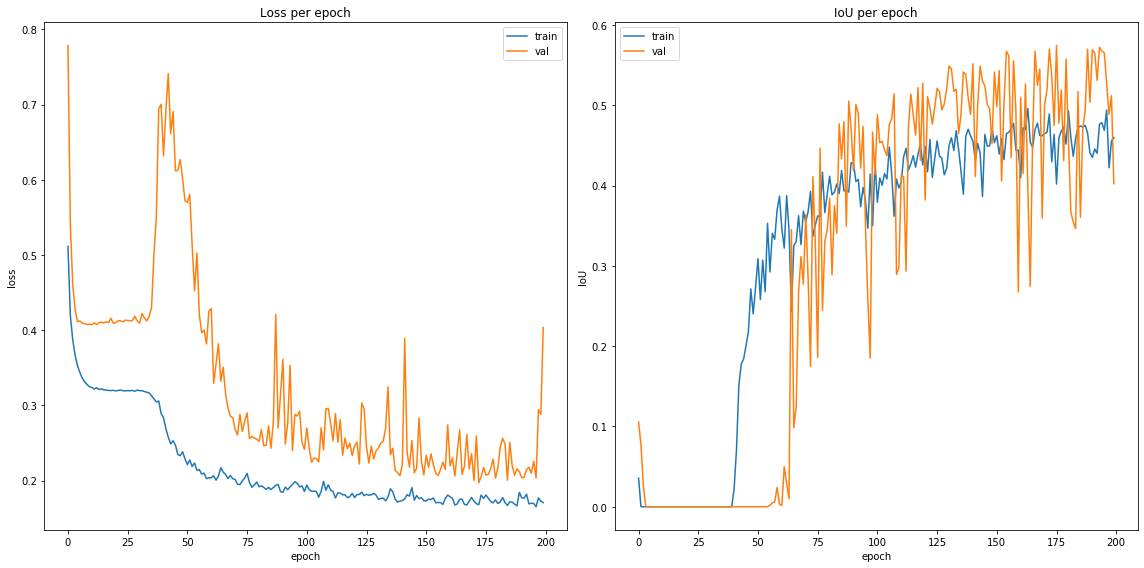

In [36]:
history = pd.DataFrame(hist.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

ax[0].plot(history.index, history['loss'], label = "train")
ax[0].plot(history.index, history['val_loss'], label = "val")
ax[0].set_title('Loss per epoch')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend()

ax[1].plot(history.index, history['iou_masked'], label = 'train')
ax[1].plot(history.index, history['val_iou_masked'], label = 'val')
ax[1].set_title('IoU per epoch')
ax[1].set_ylabel('IoU')
ax[1].set_xlabel('epoch')
ax[1].legend()

plt.tight_layout()

fig.show()

In [38]:
# Save the demo model

os.makedirs("demo_model", exist_ok=True)
with open("demo_model/configs.json", "w") as f:
    json.dump(demo_configs, f, indent=4)
model.save("demo_model/model")

INFO:tensorflow:Assets written to: demo_model/model/assets


In [ ]:
# Hyperparameter Sweep:

for rate in [.001]
{'learning_rate' : .001, 'head_size' : 1, 'threshold' : 0.}

## Testing/Visualization/Interpretation

__Todo__
- Test your model on the test data and visualize some predictions.
- What strengths and weaknesses does it have? Give specific examples.
- What would be your next steps and biggest levers to improve performance?

In [37]:


tnp = train_dataset.as_numpy_iterator()
vnp = val_dataset.as_numpy_iterator()

train_batch_np = tnp.next()
val_batch_np = vnp.next()

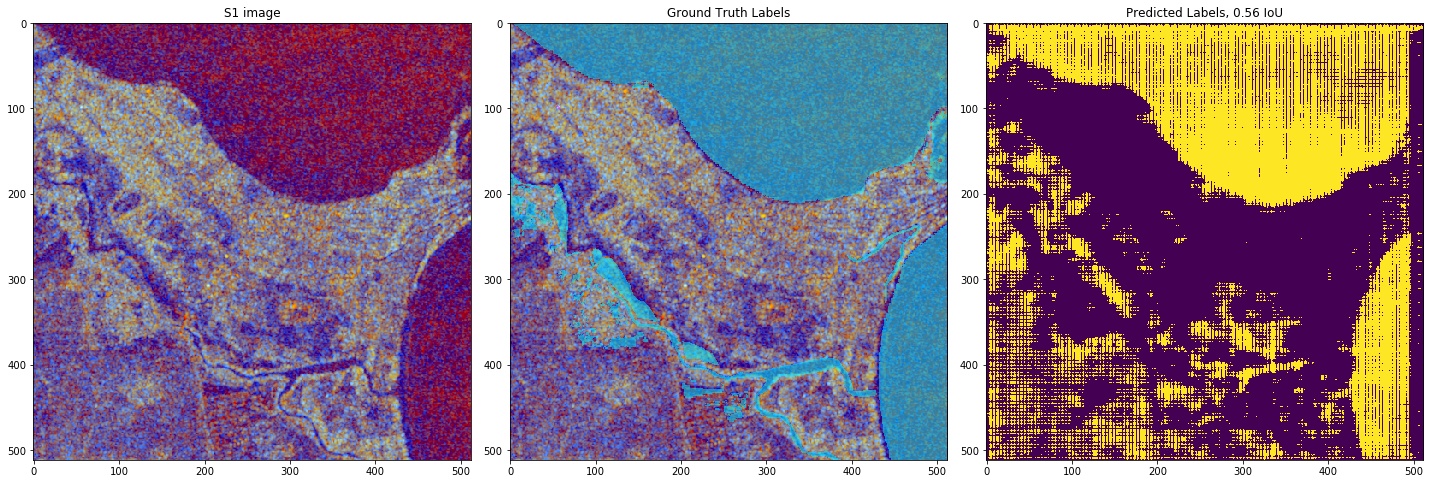

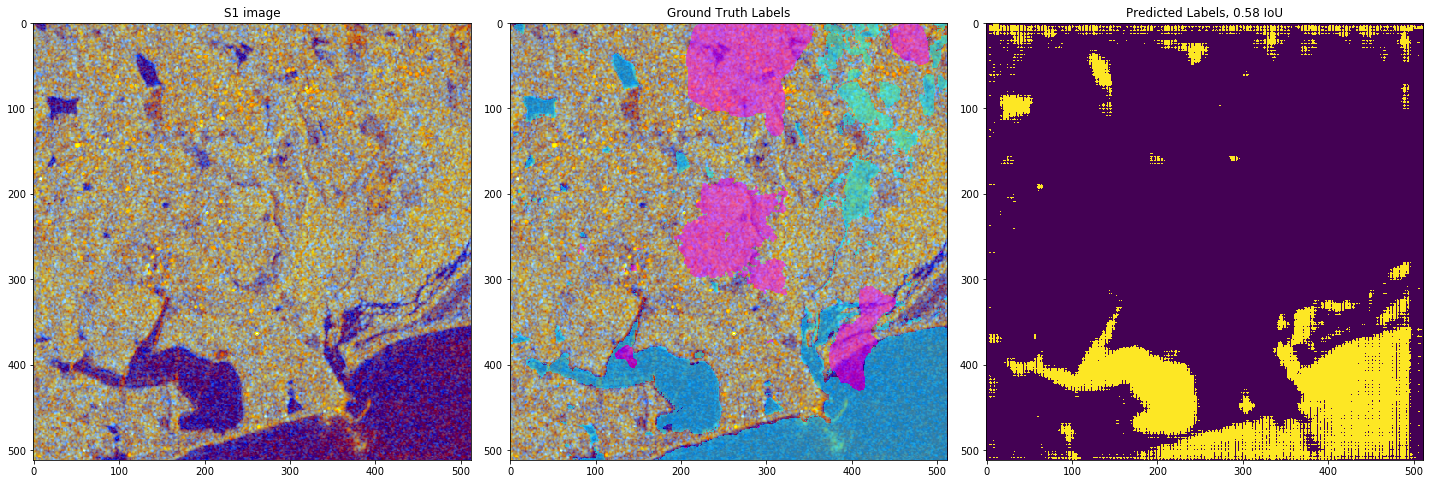

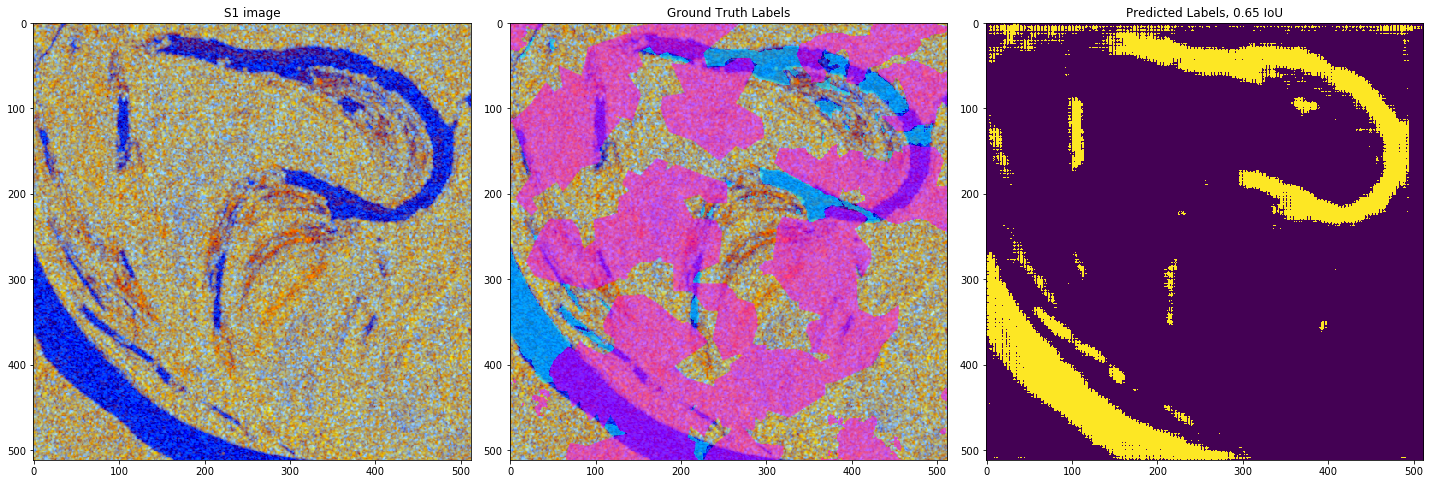

In [41]:

dataset_to_show = 'val' #options are 'train' or 'val'
show_how_many = 3
color = "cyan"
no_data_color = "magenta"
alpha = 0.5

if dataset_to_show == 'train':
    x = train_batch_np
if dataset_to_show == 'val':
    x = val_batch_np

for k in range(show_how_many):
    raw = x[0][k, :, :, :]
    prediction = model(x[0])[k, : , :]
    truth = x[1][k, : , :]
    
    f, axarr = plt.subplots(1, 3, figsize=(20, 10))
    
    axarr[0].imshow(raw)
    axarr[0].set_title("S1 image")
    
    axarr[1].imshow(raw)
    axarr[1].set_title("Ground Truth Labels")
    
    p = get_patchcollection_from_label(truth, alpha=alpha, color=color)
    axarr[1].add_collection(p)
    p = get_patchcollection_from_label(truth, -1, alpha=alpha, color=no_data_color)
    axarr[1].add_collection(p)
    
    
    axarr[2].imshow(prediction > 1.)
    
    axarr[2].set_title("Predicted Labels, %.2f IoU" % IoUMasked(threshold = 1.)(truth, prediction))
    plt.tight_layout()
    plt.show()

# Part 2: Implementing a custom model for non-standard tasks

Now, we want to design and test our own custom model that uses a standard U-Net architecture, but has custom inputs and outputs. As a starting point you can use any open-source implementation of U-Net like from [here](https://github.com/milesial/Pytorch-UNet).

__Todo: Change a standard U-Net model to work with the following non-standard inputs and outputs in a deep learning framework of your choice (preferably PyTorch).__

- __inputs__: a 10m resolution SAR image (2 channels), a 20m resolution Digital Elevation Model (1 channel) and a sequence of 8 passive microwave readings (1 channel per reading) at a 160m resolution
- __outputs__: a 10m resolution binary water segmentation mask and a 10m resolution binary cloud segmentation mask of the same height/width as the input SAR image
- test your model with input tensors with random data in it to see if intermediate and output shapes are correct

# Thanks for doing the challenge! 

Please send us everything we need to run your code to administration@cloudtostreet.info and philip@cloudtostreet.info